# Introduction to Machine Learning: Lecture9 - Gradient Boosting Methods

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import tree

### Load the diabetes dataset

In [2]:
"""explanation of the data set can be found at https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html
the features contain age, sex, bodi mass index (BMI), average blood pressure (BP), and 6 blood serum measurements.
The response of interest, a quantitative measure of disease progression one year after baseline.
Total of 442 patients.
Each column is mean centered and scaled to have variation of 1."""
diabetes_X_raw, diabetes_y = datasets.load_diabetes(return_X_y=True)
print(diabetes_X_raw.shape)

(442, 10)


### View of the features

In [3]:
df = pd.DataFrame(diabetes_X_raw, columns=['age', 'sex', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6'])
df.head()

,age,sex,BMI,BP,S1,S2,S3,S4,S5,S6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### Split to train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(diabetes_X_raw, diabetes_y, test_size=0.1, random_state=13)
print("train size: ", X_train.shape[0])
print("test size: ", X_test.shape[0])

train size:  397
test size:  45


### Train

In [5]:
#set the hyper parameters
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 5, 'learning_rate': 0.01, 'loss': 'ls'}

# Create the GBM regressor object
regr = ensemble.GradientBoostingRegressor(**params)

# Train the model using the training sets
regr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, min_samples_split=5,
                          n_estimators=500)

### Plot (train & test) loss w.r.t to number of trees
The out-sample-error is even smaller than the in-sample. This might happen in extreme cases like this where the model is very simple 

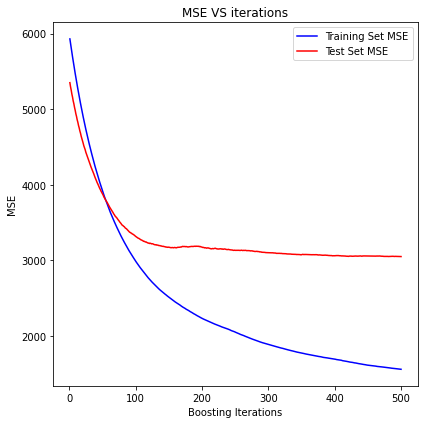

In [6]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

#Using the special "staged_predict" method to get the (aggregated) predictions after each step
for i, y_pred in enumerate(regr.staged_predict(X_test)):
    test_score[i] = regr.loss_(y_test, y_pred)

    #create plot
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('MSE VS iterations')
plt.plot(np.arange(params['n_estimators']) + 1, regr.train_score_, 'b-', label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')
fig.tight_layout()
plt.show()

# Feature importance
Plotting the importance of each feature on the training data

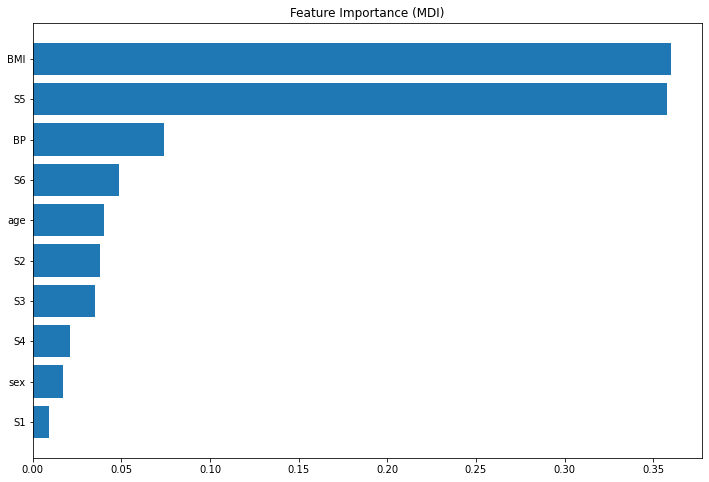

In [8]:
# get the feature importance array from the model object attribute
feature_importance = regr.feature_importances_

# get the index order to sort the importances
sorted_idx = np.argsort(feature_importance)

# plot
pos = np.arange(sorted_idx.shape[0]) + .5
plt.rcParams["figure.figsize"] = (12,8)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()

# Watch specific trees in the model

In [9]:
staged_predictions = list(regr.staged_predict(X_train))
plt.rcParams["figure.figsize"] = (21,7)  # setting the plot size
pd.set_option("precision", 3)  # the maximal number of decimals to be printed in the dataframe

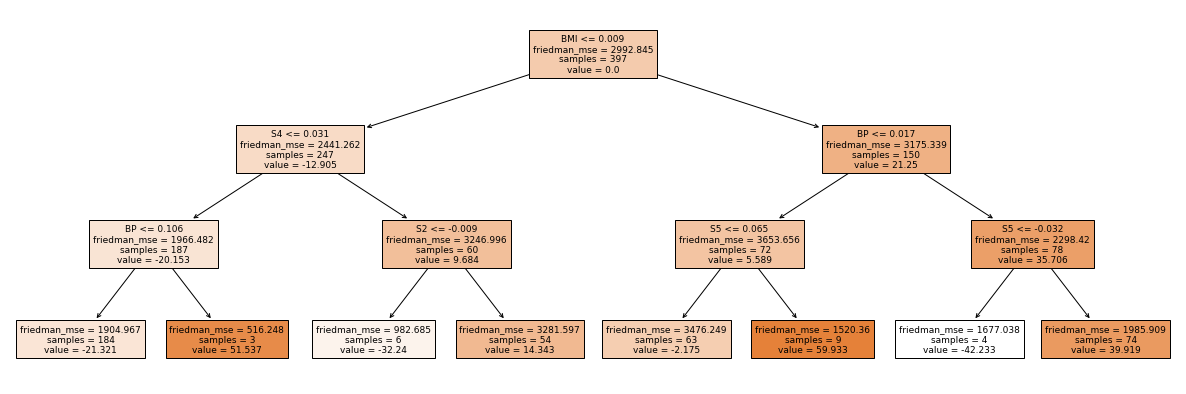

,age,sex,BMI,BP,S1,S2,S3,S4,S5,S6,label,pred_before,residual,tree_preds1,tree_preds,pred_after
0,0.067,0.051,-0.031,0.005,0.025,0.036,-0.029,0.034,0.023,0.082,172,157.326,14.674,14.343,14.343,157.470
1,0.056,0.051,-0.031,0.008,0.019,0.021,0.034,-0.039,-0.030,-0.059,91,115.357,-24.357,-21.321,-21.321,115.144
2,-0.056,-0.045,-0.074,-0.050,-0.025,-0.047,0.093,-0.076,-0.061,-0.047,48,105.654,-57.654,-21.321,-21.321,105.441
3,-0.075,0.051,-0.077,-0.047,-0.047,-0.033,0.004,-0.039,-0.072,-0.018,116,114.142,1.858,-21.321,-21.321,113.929
4,-0.089,-0.045,-0.042,-0.019,-0.066,-0.074,0.008,-0.039,0.001,-0.030,185,144.221,40.779,-21.321,-21.321,144.008
5,0.042,-0.045,-0.064,0.036,0.012,-0.058,0.181,-0.076,-0.001,-0.051,170,138.843,31.157,-21.321,-21.321,138.629
6,0.049,0.051,0.003,0.070,-0.008,0.013,-0.054,0.034,0.013,0.036,129,158.587,-29.587,14.343,14.343,158.731
7,0.042,0.051,-0.032,-0.023,-0.050,-0.040,0.030,-0.039,-0.126,0.015,104,107.483,-3.483,-21.321,-21.321,107.270
8,-0.053,0.051,0.039,-0.040,-0.006,-0.013,0.012,-0.039,0.016,0.003,85,165.422,-80.422,-2.175,-2.175,165.400
9,0.042,0.051,-0.015,-0.017,-0.006,0.008,-0.014,-0.002,-0.012,0.003,97,123.967,-26.967,-21.321,-21.321,123.754


In [10]:
tree_num = 100
number_of_samples = 10
tree.plot_tree(regr.estimators_[tree_num][0], feature_names=df.columns, filled=True, fontsize=9)
plt.show()

# Data frame of the first number_of_samples in X_train
res_df = pd.DataFrame(X_train[:number_of_samples], columns=df.columns)

# For each sample, the label is added
res_df.loc[:,'label'] = y_train[:number_of_samples].astype(int)

# For each sample, the prediction before the current tree is added
res_df.loc[:,'pred_before'] = staged_predictions[tree_num-1][:number_of_samples]

# For each sample, the current residual is added
res_df.loc[:,'residual'] = res_df['label']-res_df['pred_before']

# The prediction of each sample by the current tree - calculated directly by the current tree.
res_df.loc[:,'tree_preds1'] = regr.estimators_[tree_num][0].predict(X_train[:number_of_samples])

# The prediction of each sample by the current tree - calculated inversely from the boosting formula
res_df.loc[:,'tree_preds2'] = (1/params['learning_rate'])*(staged_predictions[tree_num][:number_of_samples]-staged_predictions[tree_num-1][:number_of_samples])

# The overall model prediction after aggregation
res_df.loc[:,'pred_after'] = staged_predictions[tree_num][:number_of_samples]
res_df.style.set_table_attributes('style="font-size: 11px"')